In [6]:
# load packages
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import bigquery
import os
import numpy as np
import pickle
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
%load_ext google.cloud.bigquery

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shimengfeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Import the Lexicon from NRC - Need to insert citation for using the lexicon

In [6]:
# /Users/shimengfeng/Documents/Master_Columbia/Fall 2019/capstone/NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92
filepath = "/Users/shimengfeng/Documents/Master_Columbia/Fall 2019/capstone/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
emolex_df.head(12)

,word,emotion,association
0,abandonment,fear,1
1,abandonment,joy,0
2,abandonment,negative,1
3,abandonment,positive,0
4,abandonment,sadness,1
5,abandonment,surprise,1
6,abandonment,trust,0
7,abate,anger,0
8,abate,anticipation,0
9,abate,disgust,0


In [11]:
#diff format
emolex_words = emolex_df.pivot(index='word', columns='emotion', values='association').reset_index()
emolex_words.head()


emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,abandonment,NaN,NaN,NaN,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2,abate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,abatement,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,abba,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
# check NA
emolex_words[emolex_words.word.isna()] 


emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#remove the first row of na
df_emolex = emolex_words.drop(0)
df_emolex.head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
1,abandonment,NaN,NaN,NaN,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2,abate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,abatement,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,abba,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,abbot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [15]:
# for score as na fill with 0
df_emolex = df_emolex.fillna(0)
df_emolex.head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
1,abandonment,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2,abate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,abatement,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,abba,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,abbot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
#show unique emotions
emotions = df_emolex.columns.drop('word')
emolex_df.emotion.unique()

array(['fear', 'joy', 'negative', 'positive', 'sadness', 'surprise',
       'trust', 'anger', 'anticipation', 'disgust'], dtype=object)

In [16]:
emolex_df[emolex_df.association == 1].emotion.value_counts()

negative        3322
positive        2312
fear            1474
anger           1245
trust           1230
sadness         1189
disgust         1058
anticipation    839 
joy             689 
surprise        534 
Name: emotion, dtype: int64

In [26]:
# words with no emotion listed, e.g. abate, removed and create a new list
df_count = emolex_df.groupby('word').sum().reset_index()
word_with_emotion_list = df_count[df_count.association !=0].word.tolist()
df_emolex_nonzero = df_emolex[df_emolex['word']. isin(word_with_emotion_list)]
df_emolex_nonzero.head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
1,abandonment,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,abba,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,abbot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10,abduction,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
11,aberrant,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [51]:
# understand how many overlapping between different emotions
# the average shows the overlap between emotions for word
overlap_sentiment = df_count[df_count.association !=0].association.mean() 

#remove positive and negative 
df_emolex_nonzero_emotions = df_emolex_nonzero.drop(columns = ['negative','positive'])
#remove the ones that ahve zero after the positive and negative 
col = df_emolex_nonzero_emotions.loc[: , "anger":"trust"]
df_emolex_nonzero_emotions['average'] = col.sum(axis=1)
df_emolex_nonzero_emotions_new = df_emolex_nonzero_emotions[df_emolex_nonzero_emotions['average'] !=0]
overlap_no_sentiment=df_emolex_nonzero_emotions_new['average'].mean()

print ('overlap with sentiment:', overlap_sentiment, '\noverlap without sentiment:', overlap_no_sentiment)

overlap with sentiment: 2.1488012374323278 
overlap without sentiment: 1.8515695067264575


In [58]:
df_count[df_count.association !=0].shape

(6465, 2)

In [56]:
df_emolex_nonzero_emotions_new.shape

(4460, 10)

In [60]:
pd.set_option("display.max_rows", 1001)
df_emolex_nonzero_emotions_new

emotion,word,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,average
1,abandonment,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,3.0
5,abbot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
10,abduction,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,3.0
12,aberration,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
14,abhor,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0
15,abhorrent,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0
18,abject,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
21,abnormal,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
24,abolish,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26,abominable,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0


### Generate dictionary for each emotion

As we can see that for each word we have about in average 2 emotions attach.

In [82]:
emotion_df = emolex_df[emolex_df.emotion =='anger']
emotion_df = emotion_df[emotion_df.association ==1]
emotion_df['word'].tolist()

['abhor',
 'abhorrent',
 'abolish',
 'abomination',
 'abuse',
 'accursed',
 'accusation',
 'accused',
 'accuser',
 'accusing',
 'actionable',
 'adder',
 'adversary',
 'adverse',
 'adversity',
 'advocacy',
 'affront',
 'aftermath',
 'aggravated',
 'aggravating',
 'aggravation',
 'aggression',
 'aggressive',
 'aggressor',
 'agitated',
 'agitation',
 'agony',
 'alcoholism',
 'alienate',
 'alienation',
 'allegation',
 'altercation',
 'ambush',
 'anarchism',
 'anarchist',
 'anarchy',
 'anathema',
 'anger',
 'angry',
 'anguish',
 'animosity',
 'animus',
 'annihilate',
 'annihilated',
 'annihilation',
 'annoy',
 'annoyance',
 'annoying',
 'antagonism',
 'antagonist',
 'antagonistic',
 'antichrist',
 'antipathy',
 'antisocial',
 'antithesis',
 'anxiety',
 'argue',
 'argument',
 'argumentation',
 'arguments',
 'armament',
 'armed',
 'arraignment',
 'arrogant',
 'arson',
 'assail',
 'assailant',
 'assassin',
 'assassinate',
 'assassination',
 'assault',
 'asshole',
 'atrocious',
 'atrocity',
 'a

In [83]:
emotion_dict = {}
for emotion in emotions:
    emotion_df = emolex_df[emolex_df.emotion ==emotion]
    emotion_df = emotion_df[emotion_df.association ==1]
    emotion_dict[emotion] = emotion_df['word'].tolist()

In [90]:
count=[len(v) for v in emotion_dict.values()]
print(count)

[1245, 839, 1058, 1474, 689, 3322, 2312, 1189, 534, 1230]


In [91]:
# save the dictionary as pickle file 
with open('NRC_emotion_lexicon_dict.pickle', 'wb') as f:
    pickle.dump(emotion_dict, f)

In [7]:
with open('NRC_emotion_lexicon_dict.pickle', 'rb') as handle:
    nrc_dict = pickle.load(handle)

## Import and pre-process twitter data from database
In our case, we will use data that do not have retweets - valid and unique tweets

In [9]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] =\
'/Users/shimengfeng/Documents/Master_Columbia/Fall 2019/capstone/\
dsi-capstone-f19-group-1-6c986cf239c5.json'

In [10]:
%%bigquery valid_tweets
SELECT DISTINCT id, full_text
FROM tweets.all_valid_tweets 
WHERE full_text not like 'RT%'
limit 10000

In [11]:
valid_tweets.head()

,id,full_text
0,500042388791099400,#annonymus found #Ferguson Police involved in shooting #MikeBrown via a digital investigation. That's what #police should do to.
1,500086635296722940,Pretty amazing live reporting from @chrislhayes tonight from #Ferguson @allinwithchris
2,501559225324437500,J. Cole Visits Mike Brown Protests in Ferguson After Releasing “Be Free” Tribute Song http://t.co/VlUOtxCQBt
3,503521739083489300,.@gofundme the @ColorOfChange community demands you take down Wilson fundraisers and return all profits. http://t.co/5YMGQJdbtX #MikeBrown
4,499806177316712450,“@BitsieTulloch: How is this an appropriate response to protests over police brutality? #Ferguson http://t.co/caJ33IAIyS”


In [43]:
#remove hashtag
import preprocessor as p
def clean_tweets (df):
    df['clean_txt'] = [p.clean(text) for text in df.full_text]
    return df
valid_tweets = clean_tweets(valid_tweets)
valid_tweets.head()
    

,id,full_text,clean_txt
0,498065922452492300,Mike Brown Believes Kobe Bryant Can Still Play At A High Level http://t.co/caNyweXavV,Mike Brown Believes Kobe Bryant Can Still Play At A High Level
1,498076913425195000,Nightmares every night since reading of #JohnCrawford being shot dead in Ohio @Walmart holding air rifle frm toy dept shelf @cspanwj #uppers,Nightmares every night since reading of being shot dead in Ohio holding air rifle frm toy dept shelf
2,498111982416171000,Sharpton says #Justice Caravans of cars/buses will go across #Verrazano Bridge into #StatenIsland 2 protest #nypd chokehold of #EricGarner,Sharpton says Caravans of cars/buses will go across Bridge into protest chokehold of
3,497979998154657800,Introducing Clear-Cut Secrets Of &lt;b&gt;mediterranean diet&lt;/b&gt;: Michael Brown and Joseph… http://t.co/qvN7Trd07z,Introducing Clear-Cut Secrets Of &lt;b&gt;mediterranean diet&lt;/b&gt;: Michael Brown and Joseph…
4,498239736524202000,They killed Eric Garner over selling imaginary cigarettes. John Crawford over a toy gun. And now this brother over some candy.,They killed Eric Garner over selling imaginary cigarettes. John Crawford over a toy gun. And now this brother over some candy.


## Apply NRC on each word of the tweet and generate emotion score

For each of the word within the cleaned text, match it back to the dictionary and calculate a overall score 

In [46]:
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")



def match_emotion (valid_tweets):
    emo_df = pd.DataFrame(0, index=valid_tweets.index, columns=emotions)

    for i, row in valid_tweets.iterrows():
        tweets = word_tokenize(valid_tweets.loc[i]['clean_txt'])
        words_count = len(tweets)
        for word in tweets:
                    word = stemmer.stem(word.lower())
                    emo_score = df_emolex[df_emolex.word == word]

                    if not emo_score.empty:
                        for emotion in list(emotions):
                            emo_df.at[i, emotion] += emo_score[emotion]
                            emo_df.at[i,'word_counts'] = words_count

    return emo_df

In [ ]:
# #change the above function to mapping in a more efficient way rather than looping through rows
# emo_df = pd.DataFrame(0, index=valid_tweets.index, columns=emotions)

# def word_emotion (sentence,nrc_dic_emotion):
#     word_list =[]
#     tweets= word_tokenize(sentence)
#     #remove stopping words
#     tweets_clean = [word for word in tweets if word not in stop_words]
#     for word in tweets_clean:
#         word = word.lower()
#         #check if the word in emotion dict
#         if word in nrc_dic_emotion:
#             word_list.append(word)
#     return word_list
            
# for emotion in emotions: 
    
#     nrc_dic_emotion = nrc_dict [emotion]
#     result = map(word_emotion, numbers) 

In [66]:
# this cell run quite long, so please call saved file rather than re-run the cell if possible
#concatenate the matrix to get the final result 
emo_df = match_emotion(valid_tweets)
new_df = pd.concat([valid_tweets, emo_df], axis=1)
#save the result to a pikle file
with open('NRC_emotion_fulltxt.pickle', 'wb') as f:
    pickle.dump(new_df, f)


new_df.head()

,id,full_text,clean_txt,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,506238048636772350,[NEW HEAT] @ClassroomMajors - Die 4 Nothin #MikeBrown #Ferguson #Justice http://t.co/ApBQtojQHr…,[NEW HEAT] - Die Nothin,0,0,0,1,0,1,0,1,0,0
1,500887656797339650,@vicenews dating tear gas @cnn saying smoke bombs #Ferguson,dating tear gas saying smoke bombs,1,0,0,1,0,1,0,1,1,0
2,501221494253715460,"#MikeBrown was shot 6 times, the 2 to the head did him in. @NewYorkTimes11 http://t.co/RV8U7yBrMw","was shot times, the to the head did him in.",1,1,0,1,0,1,0,1,1,0
3,505180621916733440,@B_boyd9 DISE - SURRENDER (FERGUSON POLICE DISS)\nA MUST SEE!!! CLICK HERE\nhttp://t.co/ouAM5V5dCv\n#RIPMIKEBROWN #FERGUSON,DISE - SURRENDER (FERGUSON POLICE DISS) A MUST SEE!!! CLICK HERE,0,0,0,0,0,0,0,0,0,0
4,499782187869171700,Witness: Teen was backing away: A witness in Michael Brown's slaying tells CNN Brown and a cop tussled at a po... http://t.co/E10jjxh0Y9,Witness: Teen was backing away: A witness in Michael Brown's slaying tells CNN Brown and a cop tussled at a po...,1,0,0,1,0,1,2,0,0,1


In [ ]:
#concatenate the matrix to get the final result 
new_df = pd.concat([valid_tweets, emo_df], axis=1)
#save the result to a pikle file
with open('NRC_emotion_cleantxt.pickle', 'wb') as f:
    pickle.dump(new_df, f)


new_df.head()

## Perform simple analysis over emotion
1. Sum up all emotions and see distribution
2. Sum up attitude (pos/ neg) and see distribution
3. Get the percentage of each emotion within a tweet (emotion distribution)
4. standardize over the total amount of words and get a relative score across tweets

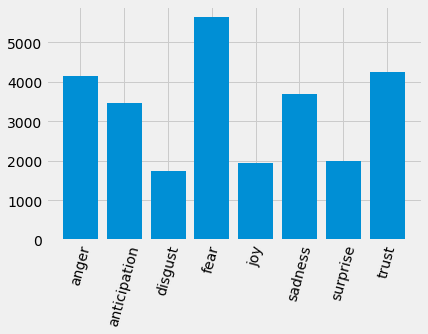

In [154]:
# sum up each emotion
df_emotion_count = pd.DataFrame(new_df.iloc[:,3:13].sum())
df_emotion_count = df_emotion_count.rename(columns={0:'count'})
df_attitude_count = df_emotion_count.loc[['negative','positive'],:]
df_emotion_count = df_emotion_count.drop(['negative','positive'])

#see overall emotions among all tweets
plt.bar(df_emotion_count.index,df_emotion_count['count'])
plt.xticks(rotation=75)
plt.show()

In [88]:
df_emotion_count

,count
anger,4157
anticipation,3469
disgust,1745
fear,5636
joy,1942
negative,7105
positive,5064
sadness,3687
surprise,2003


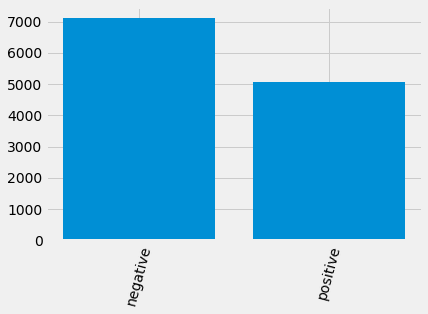

In [96]:
#see overall attitudess among all tweets
plt.bar(df_attitude_count.index,df_attitude_count['count'])
plt.xticks(rotation=75)
plt.show()

In [153]:
new_df.iloc[:,3:13].iloc[1,:].sum()

5

In [140]:
#read the pickle file
with open('NRC_emotion_cleantxt.pickle', 'rb') as f:
    new_df = pickle.load(f)
new_df.head(1)

,id,full_text,clean_txt,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,506238048636772350,[NEW HEAT] @ClassroomMajors - Die 4 Nothin #MikeBrown #Ferguson #Justice http://t.co/ApBQtojQHr…,[NEW HEAT] - Die Nothin,0,0,0,1,0,1,0,1,0,0
1,500887656797339650,@vicenews dating tear gas @cnn saying smoke bombs #Ferguson,dating tear gas saying smoke bombs,1,0,0,1,0,1,0,1,1,0
2,501221494253715460,"#MikeBrown was shot 6 times, the 2 to the head did him in. @NewYorkTimes11 http://t.co/RV8U7yBrMw","was shot times, the to the head did him in.",1,1,0,1,0,1,0,1,1,0
3,505180621916733440,@B_boyd9 DISE - SURRENDER (FERGUSON POLICE DISS)\nA MUST SEE!!! CLICK HERE\nhttp://t.co/ouAM5V5dCv\n#RIPMIKEBROWN #FERGUSON,DISE - SURRENDER (FERGUSON POLICE DISS) A MUST SEE!!! CLICK HERE,0,0,0,0,0,0,0,0,0,0
4,499782187869171700,Witness: Teen was backing away: A witness in Michael Brown's slaying tells CNN Brown and a cop tussled at a po... http://t.co/E10jjxh0Y9,Witness: Teen was backing away: A witness in Michael Brown's slaying tells CNN Brown and a cop tussled at a po...,1,0,0,1,0,1,2,0,0,1


In [157]:
#see emotion distribution for each tweets
# emotion_list = []
df_final = new_df.copy()
df_final = df_final.drop(['negative','positive'],axis =1)
df_scores = df_final.iloc[:,3:13]
# df_scores = df_scores.drop(['negative','positive'],axis =1)
for i, row in df_scores.iterrows():
    emotion_sum =df_scores.iloc[i,:].sum()
#     print(emotion_sum)
    if emotion_sum !=0:
#         emotion_list = [int(df_scores.loc[i]['anger']/emotion_sum),int(df_scores.loc[i]['anticipation']/emotion_sum),\
#                                                int(df_scores.loc[i]['disgust']/emotion_sum),int(df_scores.loc[i]['fear']/emotion_sum),\
#                                               int(df_scores.loc[i]['joy']/emotion_sum),int(df_scores.loc[i]['sadness']/emotion_sum),\
#                                               int(df_scores.loc[i]['surprise']/emotion_sum)]
        df_final.at[i,'emotion_words_sum'] = emotion_sum    
        df_final.at[i,'anger']= emotion_list = int(df_scores.loc[i]['anger']/emotion_sum)
        df_final.at[i,'anticipation%']= emotion_list = int(100*df_scores.loc[i]['anticipation']/emotion_sum)
        df_final.at[i,'disgust%']= emotion_list = int(100*df_scores.loc[i]['disgust']/emotion_sum)
        df_final.at[i,'fear%']= emotion_list = int(100*df_scores.loc[i]['fear']/emotion_sum)
        df_final.at[i,'joy%']= emotion_list = int(100*df_scores.loc[i]['joy']/emotion_sum)
        df_final.at[i,'sadness%']= emotion_list = int(100*df_scores.loc[i]['sadness']/emotion_sum)
        df_final.at[i,'surprise%']= emotion_list = int(100*df_scores.loc[i]['surprise']/emotion_sum)
        df_final.at[i,'trust%']= emotion_list = int(100*df_scores.loc[i]['trust']/emotion_sum)
        
    else:
        df_final.at[i,'emotion_words_sum'] = emotion_sum
        df_final.at[i,'fear%']= 0
        df_final.at[i,'anticipation%']= 0
        df_final.at[i,'disgust%']= 0
        df_final.at[i,'fear%']= 0
        df_final.at[i,'joy%']= 0
        df_final.at[i,'sadness%']= 0
        df_final.at[i,'surprise%']= 0
        df_final.at[i,'trust%']=0
        

In [158]:
df_final.head()

,id,full_text,clean_txt,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,anticipation%,disgust%,fear%,joy%,sadness%,surprise%,trust%
0,506238048636772350,[NEW HEAT] @ClassroomMajors - Die 4 Nothin #MikeBrown #Ferguson #Justice http://t.co/ApBQtojQHr…,[NEW HEAT] - Die Nothin,0,0,0,1,0,1,0,0,0.0,0.0,50.0,0.0,50.0,0.0,0.0
1,500887656797339650,@vicenews dating tear gas @cnn saying smoke bombs #Ferguson,dating tear gas saying smoke bombs,0,0,0,1,0,1,1,0,0.0,0.0,33.0,0.0,33.0,33.0,0.0
2,501221494253715460,"#MikeBrown was shot 6 times, the 2 to the head did him in. @NewYorkTimes11 http://t.co/RV8U7yBrMw","was shot times, the to the head did him in.",0,1,0,1,0,1,1,0,4.0,0.0,4.0,0.0,4.0,4.0,0.0
3,505180621916733440,@B_boyd9 DISE - SURRENDER (FERGUSON POLICE DISS)\nA MUST SEE!!! CLICK HERE\nhttp://t.co/ouAM5V5dCv\n#RIPMIKEBROWN #FERGUSON,DISE - SURRENDER (FERGUSON POLICE DISS) A MUST SEE!!! CLICK HERE,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,499782187869171700,Witness: Teen was backing away: A witness in Michael Brown's slaying tells CNN Brown and a cop tussled at a po... http://t.co/E10jjxh0Y9,Witness: Teen was backing away: A witness in Michael Brown's slaying tells CNN Brown and a cop tussled at a po...,0,0,0,1,0,0,0,1,0.0,0.0,50.0,0.0,0.0,0.0,50.0


## Emotion Time Series

Within this session, trying to see how does emotion shifting across the major events


In [32]:
%%bigquery valid_tweets_wave_1
SELECT  DISTINCT EXTRACT(DATE from created_at) as date, id, full_text
FROM tweets.all_valid_tweets 
WHERE full_text not like 'RT%' and EXTRACT(DATE from created_at) BETWEEN '2014-08-09' AND '2014-08-12'

In [33]:
%%bigquery valid_tweets_wave_2
SELECT  DISTINCT EXTRACT(DATE from created_at) as date, id, full_text
FROM tweets.all_valid_tweets 
WHERE full_text not like 'RT%' and EXTRACT(DATE from created_at) BETWEEN '2014-08-13' AND '2014-08-15'

In [36]:
%%bigquery valid_tweets_wave_3
SELECT  DISTINCT EXTRACT(DATE from created_at) as date, id, full_text
FROM tweets.all_valid_tweets 
WHERE full_text not like 'RT%' and EXTRACT(DATE from created_at)='2014-08-16'

In [42]:
shape_1 = valid_tweets_wave_1.shape
shape_2 = valid_tweets_wave_2.shape
shape_3 = valid_tweets_wave_3.shape

print('first_wave:', shape_1, '\nsecond_wave:', shape_2, '\nthird_wave:',shape_3)

first_wave: (180788, 3) 
second_wave: (607632, 3) 
third_wave: (107841, 3)


In [50]:
#clean up the data
tweets1 = clean_tweets(valid_tweets_wave_1)
tweets2 = clean_tweets(valid_tweets_wave_2)
tweets3 = clean_tweets(valid_tweets_wave_3)

In [47]:
# Now run emotion detection on the three different waves 
emo_df_wave1 = match_emotion(tweets1)
new_df_wave1 = pd.concat([valid_tweets, emo_df_wave1], axis=1)
#save the result to a pikle file
with open('NRC_emotion_wave1.pickle', 'wb') as f:
    pickle.dump(new_df_wave1, f)


new_df_wave1.head()

KeyboardInterrupt: 

In [92]:
# pick out a day
import datetime
day13 = tweets2[tweets2.date == datetime.date(2014, 8, 13)]
day14 = tweets2[tweets2.date == datetime.date(2014, 8, 14)]
day15 = tweets2[tweets2.date == datetime.date(2014, 8, 15)]

print(day13.shape, day14.shape, day15.shape)

(64086, 4) (341547, 4) (201999, 4)


In [68]:
emo_df_day13 = match_emotion(day13)
new_df_day13 = pd.concat([valid_tweets, emo_df_day13], axis=1)
#save the result to a pikle file
with open('NRC_emotion_day13.pickle', 'wb') as f:
    pickle.dump(new_df_day13, f)


new_df_day13.head()

,id,full_text,clean_txt,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,word_counts
0,4.980659e+17,Mike Brown Believes Kobe Bryant Can Still Play At A High Level http://t.co/caNyweXavV,Mike Brown Believes Kobe Bryant Can Still Play At A High Level,2,0,0,2,2,2,3,0,2,1,27.0
1,4.980769e+17,Nightmares every night since reading of #JohnCrawford being shot dead in Ohio @Walmart holding air rifle frm toy dept shelf @cspanwj #uppers,Nightmares every night since reading of being shot dead in Ohio holding air rifle frm toy dept shelf,0,0,0,1,0,2,0,1,0,0,19.0
2,4.981120e+17,Sharpton says #Justice Caravans of cars/buses will go across #Verrazano Bridge into #StatenIsland 2 protest #nypd chokehold of #EricGarner,Sharpton says Caravans of cars/buses will go across Bridge into protest chokehold of,0,0,0,0,0,0,0,0,0,0,NaN
3,4.979800e+17,Introducing Clear-Cut Secrets Of &lt;b&gt;mediterranean diet&lt;/b&gt;: Michael Brown and Joseph… http://t.co/qvN7Trd07z,Introducing Clear-Cut Secrets Of &lt;b&gt;mediterranean diet&lt;/b&gt;: Michael Brown and Joseph…,1,0,0,1,0,2,0,0,0,0,21.0
4,4.982397e+17,They killed Eric Garner over selling imaginary cigarettes. John Crawford over a toy gun. And now this brother over some candy.,They killed Eric Garner over selling imaginary cigarettes. John Crawford over a toy gun. And now this brother over some candy.,0,1,0,2,0,1,0,1,0,1,11.0


In [95]:
emo_df_day14 = match_emotion(day14)
new_df_day14 = pd.concat([valid_tweets, emo_df_day14], axis=1)
#save the result to a pikle file
with open('NRC_emotion_day14.pickle', 'wb') as f:
    pickle.dump(new_df_day14, f)


new_df_day14.head()

KeyboardInterrupt: 

In [ ]:
def cal_emotion_by_day (df, df_day, day_count):
    emo_df_day = match_emotion(df_day)
    new_df_day = pd.concat([df, emo_df_day], axis=1)
    #save the result to a pikle file
    file_name = 
    with open('NRC_emotion_day{}.pickle',.format(day_count), 'wb') as f:
        pickle.dump(new_df_day13, f)


new_df_day13.head()

In [51]:
emo_df_wave3 = match_emotion(tweets3)
new_df_wave3 = pd.concat([valid_tweets, emo_df_wave3], axis=1)
#save the result to a pikle file
with open('NRC_emotion_wave3.pickle', 'wb') as f:
    pickle.dump(new_df_wave3, f)


new_df_wave3.head()

KeyboardInterrupt: 

In [8]:
list_emotion1 = ['sad', 'happy', 'angry', 'joy', 'tired', 'blabla', 'yay']
tweet_text = 'Hi Shimeng I am very sad and tired'

In [9]:
l = []
for t in tweet_text.split(' '):
    if t in list_emotion1:
        l.append(t)

In [10]:
l

['sad', 'tired']